# **Skin Cancer Detection**

## **Problem Statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## About Dataset

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
The data set contains the following diseases:

Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion

## Importing libraries and understanding the data

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import warnings

%matplotlib inline

pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This problem uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("No. of train images: ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("No. of test images: ", image_count_test)

No. of train images:  2239
No. of test images:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='training', batch_size=batch_size, image_size=(img_height, img_width), seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='validation', batch_size=batch_size, image_size=(img_height, img_width), seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

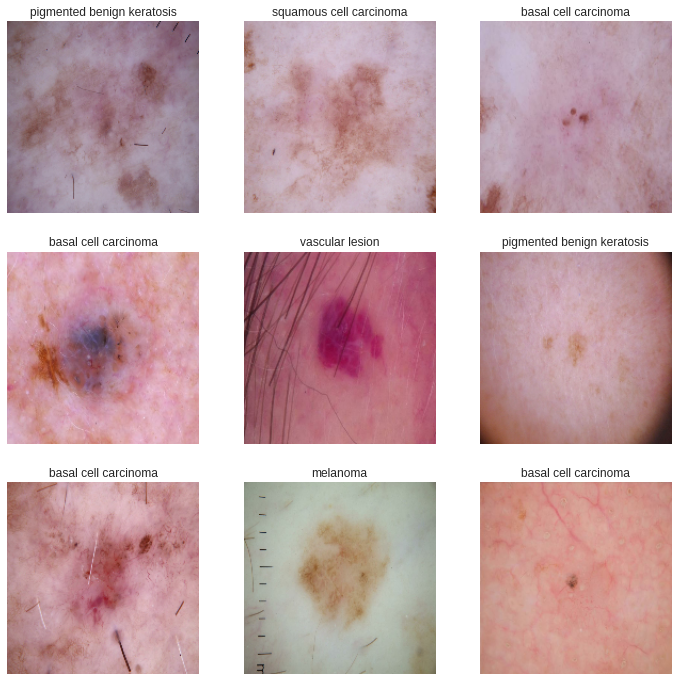

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for i in range(9):
  for img,label in train_ds.take(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [11]:
# Your code goes here

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))

model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

### Compile the model

In [12]:
# Optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 648s 3s/step - loss: 3.3657 - accuracy: 0.2065 - val_loss: 1.9294 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 4s 80ms/step - loss: 1.9110 - accuracy: 0.2694 - val_loss: 1.8074 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.7565 - accuracy: 0.3426 - val_loss: 1.8706 - val_accuracy: 0.3848
Epoch 4/20
56/56 [==============================] - 5s 81ms/step - loss: 1.5838 - accuracy: 0.4349 - val_loss: 1.5363 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 4s 80ms/step - loss: 1.3595 - accuracy: 0.5212 - val_loss: 1.5198 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 1.2791 - accuracy: 0.5419 - val_loss: 1.5068 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 5s 81ms/step - loss: 1.1570 - accuracy: 0.5884 - val_loss: 1.4775 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing training results

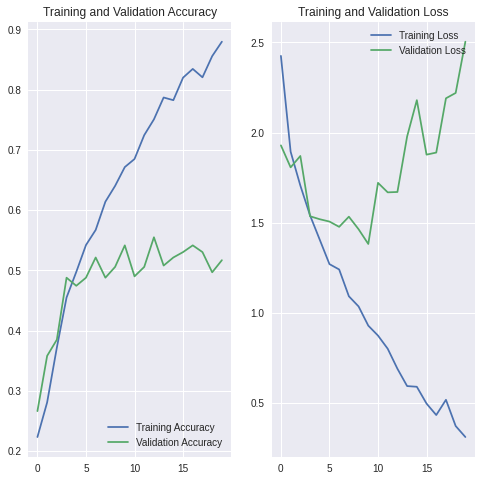

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The model above clearly overfits on the dataset with a high training accuracy of ~80% and low validation accuracy of ~50%.
As observed in the graphs above, both accuracy and loss doesn't converge and infact diverges, where validation accuracy decreases and validation loss increases whereas training accuracy increase and training loss decreases.**

In [16]:
# Data Augmentation

data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.4),
  layers.experimental.preprocessing.RandomZoom(0.25)
])

**The Data Augmentation strategy used here are:**
1. Horizontal and Vertical Flip
2. Rotation
3. Zoom

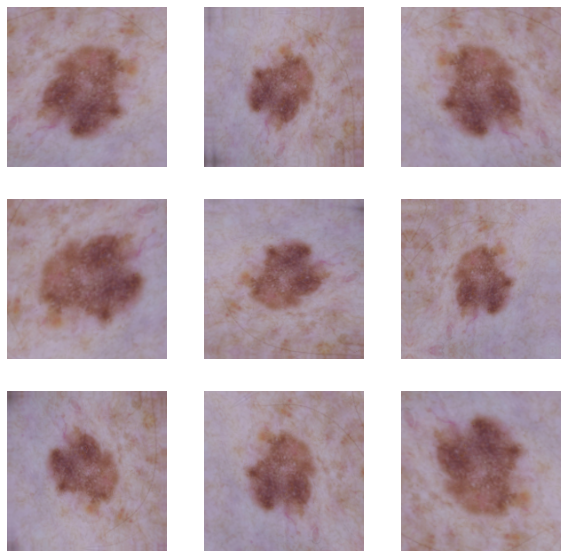

In [17]:

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  image_1 = image[0]
  for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(image_1, 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

### Create the model, compile and train the model


In [18]:

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))
model.add(data_augmentation)

model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))

model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))


### Compiling the model

In [19]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 90, 90, 64)       

### Training the model

In [20]:
## Train your model for 20 epochs

epochs=20

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs)

Epoch 1/20
56/56 [==============================] - 6s 91ms/step - loss: 2.6756 - accuracy: 0.2218 - val_loss: 1.7328 - val_accuracy: 0.4183
Epoch 2/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6741 - accuracy: 0.4085 - val_loss: 1.7029 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5503 - accuracy: 0.4448 - val_loss: 1.5067 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.4811 - accuracy: 0.4849 - val_loss: 1.5336 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.4168 - accuracy: 0.5046 - val_loss: 1.3924 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.3277 - accuracy: 0.5521 - val_loss: 1.4341 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.3795 - accuracy: 0.5148 - val_loss: 1.3621 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing the results

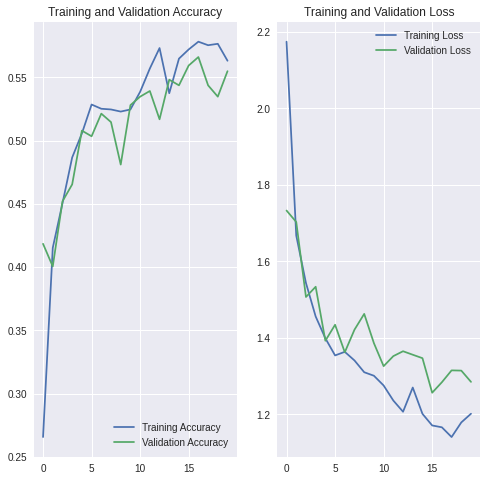

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The model is above is definetly an improvement than the previous model since now atleast the model doesn't overfit because training and validation accuracies as well as training and validation loss are converging close to each other in the plots above.
But we can observe here that the model shows low accuracy of ~60%.**


#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

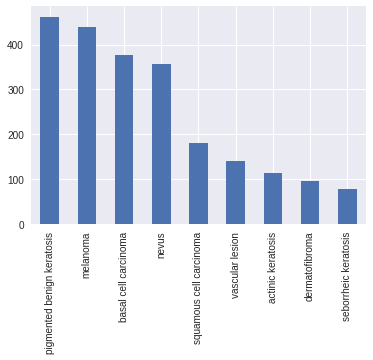

In [36]:
from glob import glob

original_path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
label_list = [os.path.basename(os.path.dirname(y)) for y in original_path_list]
dataframe_dict = dict(zip(original_path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict.items()), columns = ['Path','Label'])

original_df['Label'].value_counts().plot(kind='bar')
plt.show()

In [34]:
original_df.head()

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus
1,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus
2,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus
3,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus
4,/content/drive/MyDrive/CNN_assignment/Skin can...,nevus


#### - Which class has the least number of samples?

#### Least number of samples : Seborrheic Keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

Classes that dominate the data in terms of proportionate number of samples are:
1. Pigmented Benign Keratosis
2. Melanoma
3. Basal Cell Carcinoma
4. Nevus

#### Rectify the class imbalance
#### **Context:** Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
    
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B7AF8E350>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B7EAAB450>:   0%|          | 1/500 [00:00<01:03,  7.91 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B7AEB4150>: 100%|██████████| 500/500 [00:21<00:00, 23.36 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B7EA29510>:   0%|          | 1/500 [00:00<01:00,  8.21 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B7AF8E9D0>: 100%|██████████| 500/500 [00:23<00:00, 21.65 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F6B81343A10>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F6B81050A90>: 100%|██████████| 500/500 [01:36<00:00,  5.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B81479B10>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6B7F572050>: 100%|██████████| 500/500 [00:51<00:00,  9.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B815E1850>: 100%|██████████| 500/500 [00:22<00:00, 21.98 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6C7EDE0810>: 100%|██████████| 500/500 [00:23<00:00, 21.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
augmented_path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
augmented_path_list

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000327.jpg_e1df9d23-3bfc-4ea1-b974-d0185089ec65.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029210.jpg_9f698204-8377-4292-bba2-05301e7dab21.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000316.jpg_336b805c-3873-4b49-8f93-6f087ee923b0.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028190.jpg_d6406b18-0aca-459b-a41d-a627a8fc0ddd.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000066.jpg_8226293f-5ebd-467b-a915-c8d8ca45c88a.jpg',
 '/content/drive/MyD

In [42]:
augmented_label_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
augmented_label_list

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [43]:
augmented_dict = dict(zip(augmented_path_list, augmented_label_list))

In [44]:
augmented_df = pd.DataFrame(list(augmented_dict.items()), columns = ['Path','Label'])
augmented_df['Label'].value_counts()

pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
melanoma                      500
dermatofibroma                500
actinic keratosis             500
Name: Label, dtype: int64

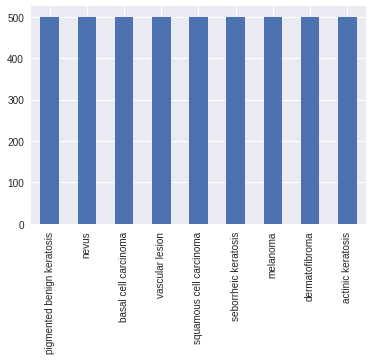

In [46]:
augmented_df['Label'].value_counts().plot(kind='bar')
plt.show()

In [48]:
new_df = original_df.append(augmented_df)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [51]:
data_dir_train="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [57]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))


#### Compile your model

In [58]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
activation_19 (Activation)   (None, 180, 180, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_20 (Activation)   (None, 90, 90, 64)       

#### Train your model

In [59]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs)

Epoch 1/50
169/169 [==============================] - 61s 349ms/step - loss: 14.4534 - accuracy: 0.2680 - val_loss: 61.4588 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 59s 341ms/step - loss: 1.6509 - accuracy: 0.3618 - val_loss: 24.3557 - val_accuracy: 0.1381
Epoch 3/50
169/169 [==============================] - 61s 351ms/step - loss: 1.4678 - accuracy: 0.4275 - val_loss: 4.2818 - val_accuracy: 0.3044
Epoch 4/50
169/169 [==============================] - 61s 354ms/step - loss: 1.4239 - accuracy: 0.4414 - val_loss: 1.4869 - val_accuracy: 0.4603
Epoch 5/50
169/169 [==============================] - 59s 343ms/step - loss: 1.3695 - accuracy: 0.4622 - val_loss: 1.4407 - val_accuracy: 0.4900
Epoch 6/50
169/169 [==============================] - 60s 348ms/step - loss: 1.2663 - accuracy: 0.4909 - val_loss: 1.2287 - val_accuracy: 0.5390
Epoch 7/50
169/169 [==============================] - 60s 349ms/step - loss: 1.1705 - accuracy: 0.5282 - val_loss: 1.7422 - val

#### Visualize the model results

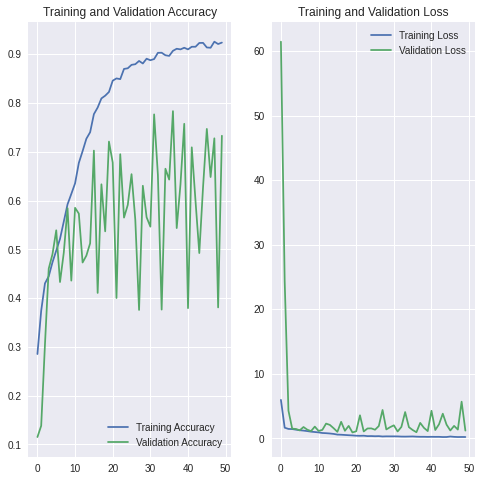

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The latest model is able to get rid of overfitting and the class rebalance helped the model to learn the data well. The model is able to label correctly the validation data with an accuracy of ~73%. Although, the model still has some room for improvement if we use more regularization techniques.**